# Autoencoders

Autoencoders are artificial neural networks capable of learning efficient representations of the input data,
called codings, without any supervision (i.e., the training set is unlabeled). 

They can be used for dimensionality reduction,
feature extraction, unsupervised pretraining, or as generative models

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2025-04-08 20:14:48.264291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

Utility functions

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

PCA with a simple linear Autoencoder

3D dataset

In [4]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [5]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

2025-04-08 20:15:50.738633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-08 20:15:50.738709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20


2025-04-08 20:16:21.427742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-08 20:16:21.457014: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


2/2 [==============================] - 1s 69ms/step - loss: 0.2882
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0649
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0306
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0213
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0218
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0219
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0192
Epoch 8/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0182
Epoch 9/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0216
Epoch 10/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0173
Epoch 11/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0154
Epoch 12/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0142
Epoch 13/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0133
E

In [7]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 9ms/step


2025-04-08 20:16:29.070160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


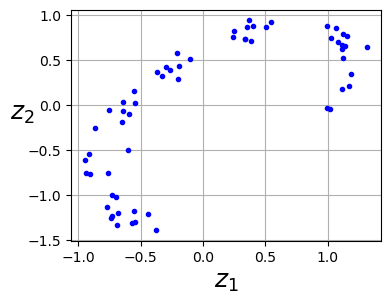

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

## Stacked Autoencoders

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Training

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20


2025-04-08 20:16:42.427852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-08 20:16:42.475783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


1719/1719 [==============================] - ETA: 0s - loss: 0.3376 - rounded_accuracy: 0.8875

2025-04-08 20:17:13.984762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 34s 19ms/step - loss: 0.3376 - rounded_accuracy: 0.8875 - val_loss: 0.3147 - val_rounded_accuracy: 0.9029
Epoch 2/20
1719/1719 [==============================] - 32s 19ms/step - loss: 0.3058 - rounded_accuracy: 0.9148 - val_loss: 0.3059 - val_rounded_accuracy: 0.9186
Epoch 3/20
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2994 - rounded_accuracy: 0.9206 - val_loss: 0.2982 - val_rounded_accuracy: 0.9215
Epoch 4/20
1719/1719 [==============================] - 32s 18ms/step - loss: 0.2955 - rounded_accuracy: 0.9241 - val_loss: 0.2945 - val_rounded_accuracy: 0.9267
Epoch 5/20
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2927 - rounded_accuracy: 0.9266 - val_loss: 0.2931 - val_rounded_accuracy: 0.9263
Epoch 6/20
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2907 - rounded_accuracy: 0.9284 - val_loss: 0.2916 - val_rounded_accuracy: 0.9306
Epoch 7/20
1719/1719 [=================

In [12]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    # fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 28ms/step


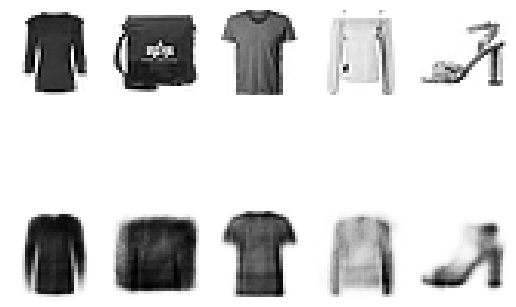

In [15]:
show_reconstructions(stacked_ae)

## Visualizing Fashion MNIST

In [16]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

 53/157 [=========>....................] - ETA: 0s

2025-04-08 20:28:34.456389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 1s 3ms/step
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


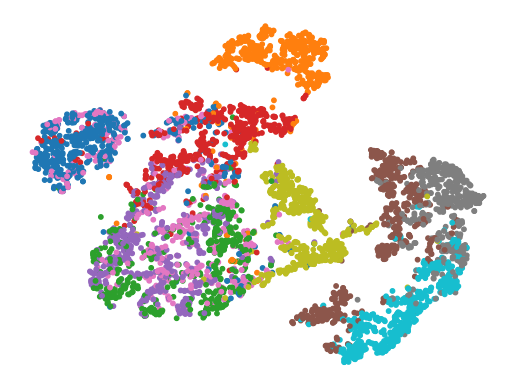

In [17]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Better diagram

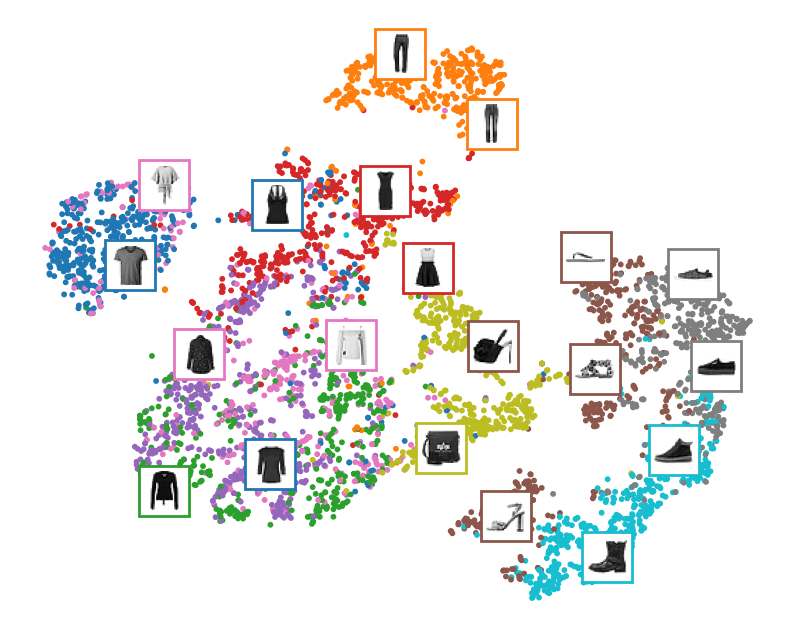

In [18]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

Tying weights

In [19]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10


2025-04-08 20:29:06.056499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-08 20:29:06.106317: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


1719/1719 [==============================] - ETA: 0s - loss: 0.3262 - rounded_accuracy: 0.8967

2025-04-08 20:29:37.550619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 34s 19ms/step - loss: 0.3262 - rounded_accuracy: 0.8967 - val_loss: 0.3067 - val_rounded_accuracy: 0.9096
Epoch 2/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.2972 - rounded_accuracy: 0.9227 - val_loss: 0.3007 - val_rounded_accuracy: 0.9256
Epoch 3/10
1719/1719 [==============================] - 32s 19ms/step - loss: 0.2915 - rounded_accuracy: 0.9280 - val_loss: 0.2916 - val_rounded_accuracy: 0.9271
Epoch 4/10
1719/1719 [==============================] - 32s 19ms/step - loss: 0.2887 - rounded_accuracy: 0.9306 - val_loss: 0.2881 - val_rounded_accuracy: 0.9324
Epoch 5/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.2867 - rounded_accuracy: 0.9323 - val_loss: 0.2890 - val_rounded_accuracy: 0.9288
Epoch 6/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.2853 - rounded_accuracy: 0.9336 - val_loss: 0.2867 - val_rounded_accuracy: 0.9330
Epoch 7/10
1719/1719 [=================

1/1 [==============================] - 0s 27ms/step


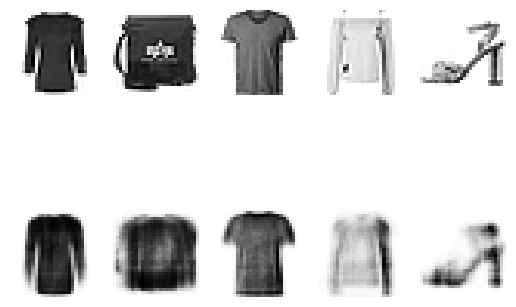

In [22]:
show_reconstructions(tied_ae)
plt.show()

Training single autoencoder at

In [23]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [24]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10


2025-04-08 20:35:31.672095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-08 20:35:31.706159: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


1719/1719 [==============================] - ETA: 0s - loss: 0.3445 - rounded_accuracy: 0.8877

2025-04-08 20:35:54.013625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 24s 13ms/step - loss: 0.3445 - rounded_accuracy: 0.8877 - val_loss: 0.3110 - val_rounded_accuracy: 0.9163
Epoch 2/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.3027 - rounded_accuracy: 0.9215 - val_loss: 0.2994 - val_rounded_accuracy: 0.9256
Epoch 3/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.2939 - rounded_accuracy: 0.9294 - val_loss: 0.2925 - val_rounded_accuracy: 0.9320
Epoch 4/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2884 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9366
Epoch 5/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2847 - rounded_accuracy: 0.9382 - val_loss: 0.2851 - val_rounded_accuracy: 0.9395
Epoch 6/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2821 - rounded_accuracy: 0.9408 - val_loss: 0.2829 - val_rounded_accuracy: 0.9412
Epoch 7/10
1719/1719 [=================

2025-04-08 20:39:14.214323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-08 20:39:14.237987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


1719/1719 [==============================] - ETA: 0s - loss: 0.5668

2025-04-08 20:39:30.643000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 17s 10ms/step - loss: 0.5668 - val_loss: 0.3157
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2563 - val_loss: 0.2409
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2210 - val_loss: 0.2157
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2121 - val_loss: 0.2082
Epoch 5/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2077 - val_loss: 0.2027
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2049 - val_loss: 0.1979
Epoch 7/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.1979 - val_loss: 0.1948
Epoch 8/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.1923 - val_loss: 0.1918
Epoch 9/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.1916 - val_loss: 0.1882
Epoch 10/10
1719/1719 [==============================] - 17s 10ms/step - lo

In [25]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 26ms/step


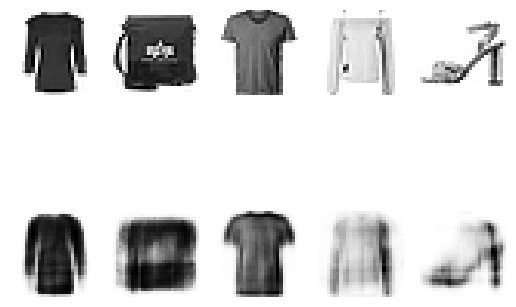

In [27]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()